In [22]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]


In [23]:
zaps = dt.get_zaps()
posts = dt.get_posts()
comments = dt.get_comments()

mask = (posts['invoiceActionState'] != 'FAILED') & \
       (~posts['bio']) & (~posts['freebie']) & (~posts['saloon']) & \
       (posts['subName'].notnull()) & (posts['subName'] != '') & \
       (~posts['subName'].isin(['jobs', 'ama']))

posts = posts.loc[mask].reset_index(drop=True)

mask = (comments['invoiceActionState'] != 'FAILED')

comments = comments.loc[mask].reset_index(drop=True)

In [24]:
# distribution of zaps by time
right = posts[['itemId', 'created_at']].rename(
    columns = {'created_at': 'post_created_at'}
).reset_index(drop=True)
zaps = zaps.merge(right, on='itemId', how='inner')
zaps['hours_after_post'] = np.ceil((zaps['zap_time'] - zaps['post_created_at']).dt.total_seconds() / 3600)
zaps['total_sats'] = zaps.groupby('itemId')['sats'].transform('sum')
zaps.loc[zaps['hours_after_post'] > 48, 'hours_after_post'] = 49


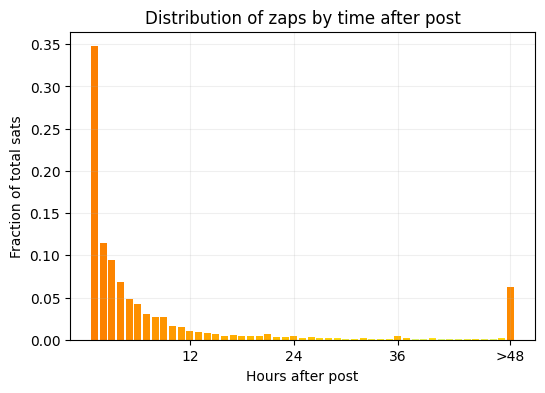

In [25]:
hours = zaps.groupby(['hours_after_post']).agg(
    sats = ('sats', 'sum')
).reset_index()
hours['frac'] = hours['sats'] / hours['sats'].sum()
hours = hours.sort_values(by='frac', ascending=True).reset_index(drop=True)
colors = plt.cm.Wistia(np.linspace(0.0,1,len(hours)))
plt.figure(figsize=(6,4))
plt.bar(hours['hours_after_post'], hours['frac'], color=colors)
plt.xticks(ticks=[12, 24, 36, 49], labels=['12', '24', '36', '>48'])
plt.xlabel('Hours after post')
plt.ylabel('Fraction of total sats')
plt.grid(alpha=0.2)
plt.title('Distribution of zaps by time after post')
plt.show()

In [26]:
# distribution of comments by time
right = posts[['itemId', 'created_at']].rename(
    columns = {'itemId': 'rootId', 'created_at': 'post_created_at'}
).reset_index(drop=True)
comments = comments.merge(right, on='rootId', how='inner')
comments['hours_after_post'] = np.ceil((comments['created_at'] - comments['post_created_at']).dt.total_seconds() / 3600)
comments.loc[comments['hours_after_post'] > 48, 'hours_after_post'] = 49

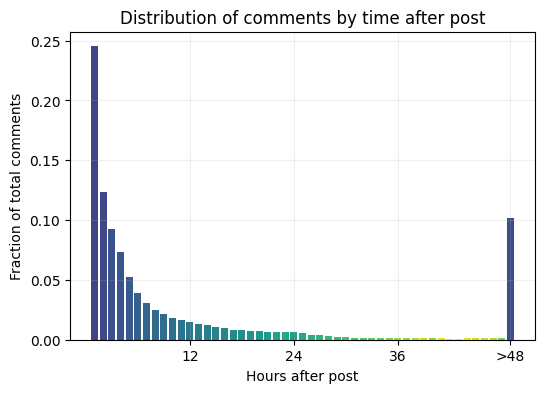

In [27]:
hours = comments.groupby(['hours_after_post']).agg(
    n_comments = ('itemId', 'count')
).reset_index()
hours['frac'] = hours['n_comments'] / hours['n_comments'].sum()
hours = hours.sort_values(by='frac', ascending=True).reset_index(drop=True)
colors = plt.cm.viridis_r(np.linspace(0.0,0.8,len(hours)))
plt.figure(figsize=(6,4))
plt.bar(hours['hours_after_post'], hours['frac'], color=colors)
plt.xticks(ticks=[12, 24, 36, 49], labels=['12', '24', '36', '>48'])
plt.xlabel('Hours after post')
plt.ylabel('Fraction of total comments')
plt.grid(alpha=0.2)
plt.title('Distribution of comments by time after post')
plt.show()

In [28]:
zaps = zaps.loc[zaps['hours_after_post'] <= 48].reset_index(drop=True)
zaps48 = zaps.groupby('itemId').agg(
    sats48 = ('sats', 'sum')
).reset_index()

comments = comments.loc[comments['hours_after_post'] <= 48].reset_index(drop=True)
comments48 = comments.groupby('rootId').agg(
    n_comments48 = ('itemId', 'count')
).reset_index().rename(columns={'rootId': 'itemId'})

posts = posts.merge(zaps48, on='itemId', how='left')
posts['sats48'] = posts['sats48'].fillna(0)

posts = posts.merge(comments48, on='itemId', how='left')
posts['n_comments48'] = posts['n_comments48'].fillna(0)

posts = dt.find_subowner(posts)

mask = (posts['userId'] != posts['subOwner']) & \
       (posts['cost'] > 0)
posts = posts.loc[mask].reset_index(drop=True)

In [29]:
outdf = posts.copy()
outdf['week'] = outdf['created_at'].dt.to_period('W-SAT').dt.start_time
outdf['subId'], uniques = pd.factorize(outdf['subName'])
outdf['weekId'], uniques = pd.factorize(outdf['week'])

keep_cols = ['itemId', 'userId', 'created_at', 'title', 'text', 'subName', 'subId',
             'week', 'weekId', 'cost', 'sats48', 'n_comments48']
outdf = outdf[keep_cols]
outdf.to_csv(os.path.join(DATA_PATH, 'posts_quality_regs.csv'), index=False)

C:\Users\edwar\AppData\Local\Temp\ipykernel_9952\1872106568.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  outdf['week'] = outdf['created_at'].dt.to_period('W-SAT').dt.start_time


In [30]:
res = subprocess.run([R_PATH, LOCAL_PATH + "/src/R/playground.R"], check=True, capture_output=True, text=True)
print(res.stdout)


                                                  Dependent variable:                              
                    -------------------------------------------------------------------------------
                                                      log_sats48                                   
                            (1)                 (2)                 (3)                 (4)        
---------------------------------------------------------------------------------------------------
log_cost                 0.335***            0.226***            0.237***            0.104***      
                          (0.003)             (0.003)             (0.007)             (0.007)      
                                                                                                   
Constant                 2.775***                                                                  
                          (0.008)                                                                  

In [32]:
fedf = pd.read_csv(os.path.join(DATA_PATH, 'reg_sats_2.csv'))

sub_fe = fedf.loc[fedf['fe']=='subId'].reset_index(drop=True)
week_fe = fedf.loc[fedf['fe']=='weekId'].reset_index(drop=True)
user_fe = fedf.loc[fedf['fe']=='userId'].reset_index(drop=True)

sub_fe = sub_fe.rename(columns={'idx': 'subId'})
week_fe = week_fe.rename(columns={'idx': 'weekId'})
user_fe = user_fe.rename(columns={'idx': 'userId'})

sub_fe = sub_fe.merge(
    outdf[['subId', 'subName']].drop_duplicates(), on='subId', how='left'
)
week_fe = week_fe.merge(
    outdf[['weekId', 'week']].drop_duplicates(), on='weekId', how='left'
)
user_fe = user_fe.merge(
    outdf[['userId']].drop_duplicates(), on='userId', how='left'
)


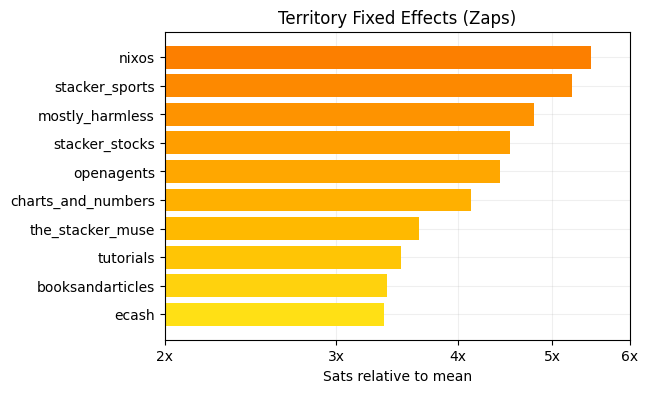

In [33]:
# territory fe chart

sub_fe['effect'] = sub_fe['effect'] - sub_fe['effect'].mean()
sub_fe = sub_fe.sort_values('effect', ascending=False).reset_index(drop=True)
plot_df = sub_fe.loc[sub_fe['obs']>30].head(10)
colors = plt.cm.Wistia(np.linspace(0.3,1,len(plot_df)))
plt.figure(figsize=(6,4))
plt.barh(plot_df['subName'][::-1], np.exp(plot_df['effect'][::-1]), color=colors)
plt.xscale('log')
plt.xticks([2, 3, 4, 5, 6], ['2x', '3x', '4x', '5x', '6x'])
plt.xlabel("Sats relative to mean")
plt.title("Territory Fixed Effects (Zaps)")
plt.grid(alpha=0.2, zorder=0)
plt.gca().set_axisbelow(True)

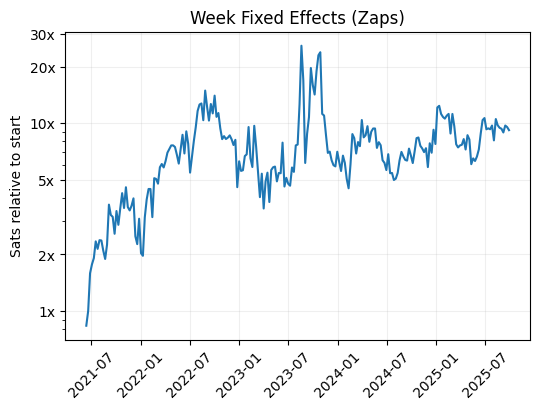

In [34]:
# zap generosity over time
week_fe['effect'] = week_fe['effect'] - week_fe['effect'].iloc[0]
plt.figure(figsize=(6,4))
plt.plot(week_fe['week'][1:-1], np.exp(week_fe['effect'][1:-1]))
plt.xticks(rotation=45)
plt.grid(alpha=0.2, zorder=0)
plt.gca().set_axisbelow(True)
plt.yscale('log')
plt.yticks([1, 2, 5, 10, 20, 30], ['1x', '2x', '5x', '10x', '20x', '30x'])
plt.ylabel('Sats relative to start')
plt.title('Week Fixed Effects (Zaps)')
plt.show()

In [35]:
fedf = pd.read_csv(os.path.join(DATA_PATH, 'reg_ncomments_2.csv'))

sub_fe = fedf.loc[fedf['fe']=='subId'].reset_index(drop=True)
week_fe = fedf.loc[fedf['fe']=='weekId'].reset_index(drop=True)
user_fe = fedf.loc[fedf['fe']=='userId'].reset_index(drop=True)

sub_fe = sub_fe.rename(columns={'idx': 'subId'})
week_fe = week_fe.rename(columns={'idx': 'weekId'})
user_fe = user_fe.rename(columns={'idx': 'userId'})

sub_fe = sub_fe.merge(
    outdf[['subId', 'subName']].drop_duplicates(), on='subId', how='left'
)
week_fe = week_fe.merge(
    outdf[['weekId', 'week']].drop_duplicates(), on='weekId', how='left'
)
user_fe = user_fe.merge(
    outdf[['userId']].drop_duplicates(), on='userId', how='left'
)


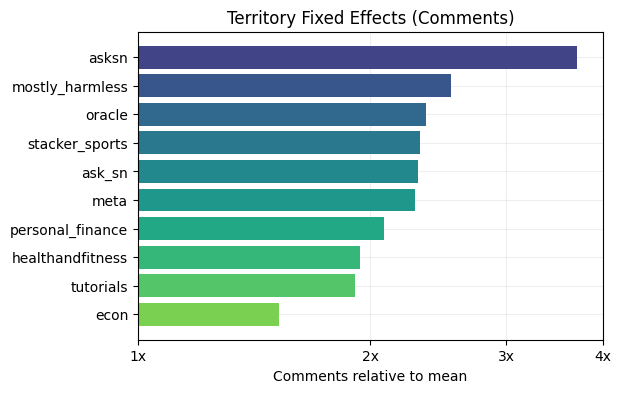

In [37]:
# territory fe chart

sub_fe['effect'] = sub_fe['effect'] - sub_fe['effect'].mean()
sub_fe = sub_fe.sort_values('effect', ascending=False).reset_index(drop=True)
plot_df = sub_fe.loc[sub_fe['obs']>30].head(10)
colors = plt.cm.viridis_r(np.linspace(0.2,0.8,len(plot_df)))
plt.figure(figsize=(6,4))
plt.barh(plot_df['subName'][::-1], np.exp(plot_df['effect'][::-1]), color=colors)
plt.xscale('log')
plt.xticks([1, 2, 3, 4], ['1x', '2x', '3x', '4x'])
plt.xlabel("Comments relative to mean")
plt.title("Territory Fixed Effects (Comments)")
plt.grid(alpha=0.2, zorder=0)
plt.gca().set_axisbelow(True)

In [41]:
np.exp( 0.059*(np.log(2) - np.log(1))) - 1

0.041743429008221256